# Configure Your Pipeline

Before running the notebook, make sure to set the following parameters according to your needs:

- **MODEL** — choose the machine learning model to use:
  `"RandomForest"` or `"LogisticRegression"`

- **DATASET** — select which dataset to process:
  `"OpenStack"` or `"Linux"`

- **SKIP_PIPELINE** — set to `True` if you want to skip the preprocessing pipeline (use existing CSVs), or `False` to run the full pipeline.


In [53]:
MODEL = "RandomForest" # Options: "RandomForest", "LogisticRegression"
DATASET = "Linux"  # Options: "OpenStack", "Linux"
SKIP_PIPELINE = False

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from pipeline import run_pipeline

Parsing file: C:\Users\yanth\PycharmProjects\logging-prediction\resources/linux/log\Linux.log
Total lines:  2000
Processed 50.0% of log lines.
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:00.169999]
Index(['Unnamed: 0', 'LineId', 'Month', 'Day', 'Time', 'Machine', 'Service',
       'PID', 'Content', 'EventId', 'EventTemplate', 'ParameterList',
       'Severity'],
      dtype='object')
(2000, 13)
Dropped 8 FAILURE events from the event matrix.
Severity
1    115
0    110
Name: count, dtype: int64
C:\Users\yanth\PycharmProjects\logging-prediction


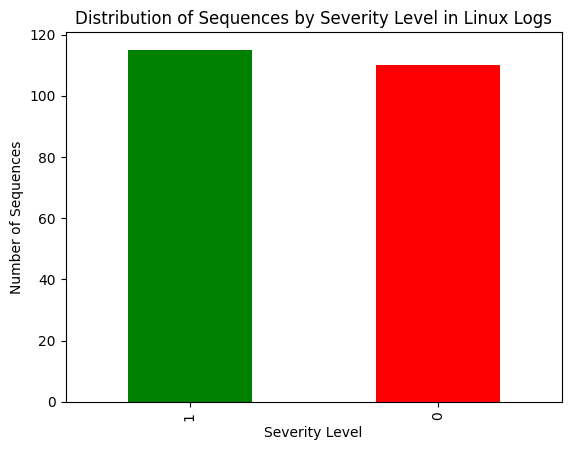

In [55]:
df = run_pipeline(DATASET, SKIP_PIPELINE)

In [56]:
X = df.iloc[:, 1:-1].values
y = df["Severity"].values

# 10-Fold Cross-Validation Setup

In [57]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [58]:
if MODEL == "RandomForest":
    model = RandomForestClassifier(
        n_estimators=100,  # number of trees
        max_depth=None,    # let trees expand until all leaves are pure
        random_state=42
    )
elif MODEL == "LogisticRegression":
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
else:
    raise ValueError(f"Unsupported model {MODEL}, please choose either 'RandomForest' or 'LogisticRegression'.")



# Model Evaluation Across Folds

In [59]:
accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []

y_true_all = []
y_pred_all = []
y_proba_all = []


for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # probabilities for class 1

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_proba_all.extend(y_proba)

    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_proba))

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_proba_all = np.array(y_proba_all)

metrics = {
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "AUC": aucs
}

metric_names = list(metrics.keys())
means = [np.mean(metrics[m]) for m in metric_names]
stds = [np.std(metrics[m]) for m in metric_names]

for name, mean, std in zip(metric_names, means, stds):
    print(f"{name}: {mean:.4f} ± {std:.4f}")


Accuracy: 0.8308 ± 0.0834
Precision: 0.8130 ± 0.1077
Recall: 0.8856 ± 0.0985
AUC: 0.9349 ± 0.0604


# Visualizations : Confusion Matrix

<Figure size 500x500 with 0 Axes>

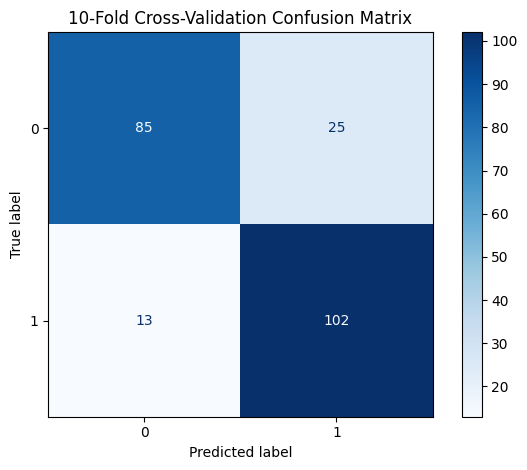

In [60]:
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", colorbar=True)
plt.title("10-Fold Cross-Validation Confusion Matrix")
plt.tight_layout()
plt.savefig(f"resources/images/cv_confusion_matrix_{MODEL}_{DATASET}.png", dpi=300)
plt.show()

# Feature Importance Analysis

In [61]:
event_names = list(df.columns)[1:-1]

if MODEL == "LogisticRegression":
    coefficients = model.coef_[0]
    importance = np.abs(coefficients)
elif MODEL == "RandomForest":
    importance = abs(model.feature_importances_)

feature_importance = pd.DataFrame({
    "EventId": event_names,
    "Importance": importance
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance.head(10))

     EventId  Importance
63  8f0f7d7f    0.395781
73  a82d5ea6    0.157989
28  39d9635b    0.129354
19  27624832    0.098430
80  b780997e    0.058885
2   09789b2b    0.054869
53  6f97e9d4    0.021759
86  d6254e1a    0.021718
1   03649f38    0.011830
54  78490a8a    0.011738


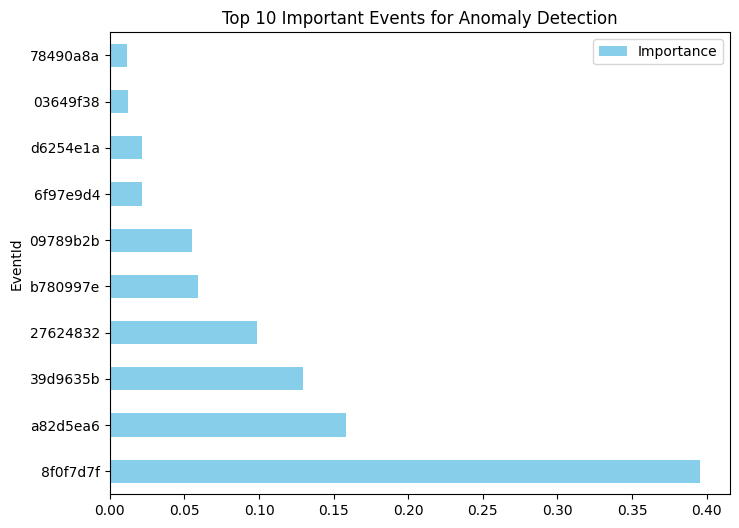

In [62]:
import matplotlib.pyplot as plt

feature_importance.head(10).plot(
    x="EventId", y="Importance", kind="barh", figsize=(8,6), color="skyblue"
)
plt.title("Top 10 Important Events for Anomaly Detection")
plt.savefig(f"resources/images/top10_feature_importance_{MODEL}_{DATASET}.png", dpi=300)
plt.show()
